<a href="https://colab.research.google.com/github/LUUTHIENXUAN/Visual-Attention-Network/blob/main/Image_classification_with_Visual_Attention_Network_(VAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification Visual Attention Network (VAN)

**Author:** [LUUTHIENXUAN](https://www.linkedin.com/in/thienxuanluu/)<br>
**PyTorch implementation** [LINK](https://github.com/Visual-Attention-Network/VAN-Classification/tree/ccdfc6883d0da136010bb8cea52bec3587ffb250)<br>

**Date created:** 2022/05/08<br>
**Last modified:** 2022/05/08<br>
**Description:** Implementing the Visual Attention Network (VAN) model for image classification.

## Introduction

An implementation of [Visual Attention Network (VAN)](https://arxiv.org/pdf/2202.09741.pdf)
model for image classification,
and demonstrates it on the CIFAR-100 dataset.This example requires TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
which can be installed using the following command:

```python
pip install -U tensorflow-addons
```

## Citation:
```
@article{guo2022visual,
  title={Visual Attention Network},
  author={Guo, Meng-Hao and Lu, Cheng-Ze and Liu, Zheng-Ning and Cheng, Ming-Ming and Hu, Shi-Min},
  journal={arXiv preprint arXiv:2202.09741},
  year={2022}
}
```


## Setup

In [1]:
!pip install -U tensorflow-addons

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers
from tensorflow.keras import backend as K
from keras.utils.conv_utils import normalize_tuple
from keras.utils.control_flow_util import smart_cond
import tensorflow_addons as tfa

import math
import warnings

## Prepare the data

In [3]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 30

image_size = 72  # We'll resize input images to this size

## Use data augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)





In [6]:
class Mlp(layers.Layer):
  def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=tfa.layers.GELU, drop=0.):
    super(Mlp, self).__init__()
    
    out_features = out_features or in_features
    hidden_features = hidden_features or in_features
    """
    fan_out = kernel_size[0] * kernel_size[1] * features // group
    """
    #fan_out = 1 * 1 * hidden_features // 1
    self.fc1 = layers.Conv2D(hidden_features, 1,
            kernel_initializer=tf.keras.initializers.RandomNormal(0., math.sqrt(2. / hidden_features)))
    #fan_out = 3 * 3 * 1 // 1
    self.dwconv = layers.DepthwiseConv2D(3, padding='same',
            kernel_initializer=tf.keras.initializers.RandomNormal(0., math.sqrt(2. / 9)))
    #fan_out = 1 * 1 * out_features // 1
    self.fc2 = layers.Conv2D(out_features, 1,
            kernel_initializer=tf.keras.initializers.RandomNormal(0., math.sqrt(2. / out_features)))
    
    self.act = act_layer()
    self.drop = layers.Dropout(drop)
  
  @tf.function(jit_compile=True)
  def call(self, x):
 
    x = self.fc1(x)
    x = self.dwconv(x)
    x = self.act(x)
    x = self.drop(x)
    x = self.fc2(x)
    x = self.drop(x)
    
    return x

## Implement the patch encoding layer


In [7]:
class OverlapPatchEmbed(layers.Layer):
  """ Image to Patch Embedding
  """
  def __init__(self, img_size=224, patch_size=7, stride=4, embed_dim=768):
    super(OverlapPatchEmbed, self).__init__()
    
    self.proj = layers.Conv2D(embed_dim, kernel_size= patch_size, strides= stride, name='proj',
                              kernel_initializer=tf.keras.initializers.RandomNormal(0., math.sqrt(2. / embed_dim)))
    self.norm = layers.BatchNormalization(name='norm', epsilon=1.001e-5)
  
  @tf.function(jit_compile=True)
  def call(self, x):
    x = self.proj(x)
    x = self.norm(x)        
    return x

## Build the VAN model

While originally designed for natural language processing (NLP) tasks, the self-attention mechanism has recently taken various computer vision areas by storm. However, the 2D nature of images brings three challenges for applying self-attention in computer vision. (1) Treating images as 1D sequences neglects their 2D structures. (2) The quadratic complexity is too expensive for high-resolution images. (3) It only captures spatial adaptability but ignores channel adaptability. In this paper, we propose a novel large kernel attention (LKA) module to enable self-adaptive and long-range correlations in self-attention while avoiding the above issues. We further introduce a novel neural network based on LKA, namely Visual Attention Network (VAN). While extremely simple and efficient, VAN outperforms the state-of-the-art vision transformers (ViTs) and convolutional neural networks (CNNs) with a large margin in extensive experiments, including image classification, object detection, semantic segmentation, instance segmentation, etc.

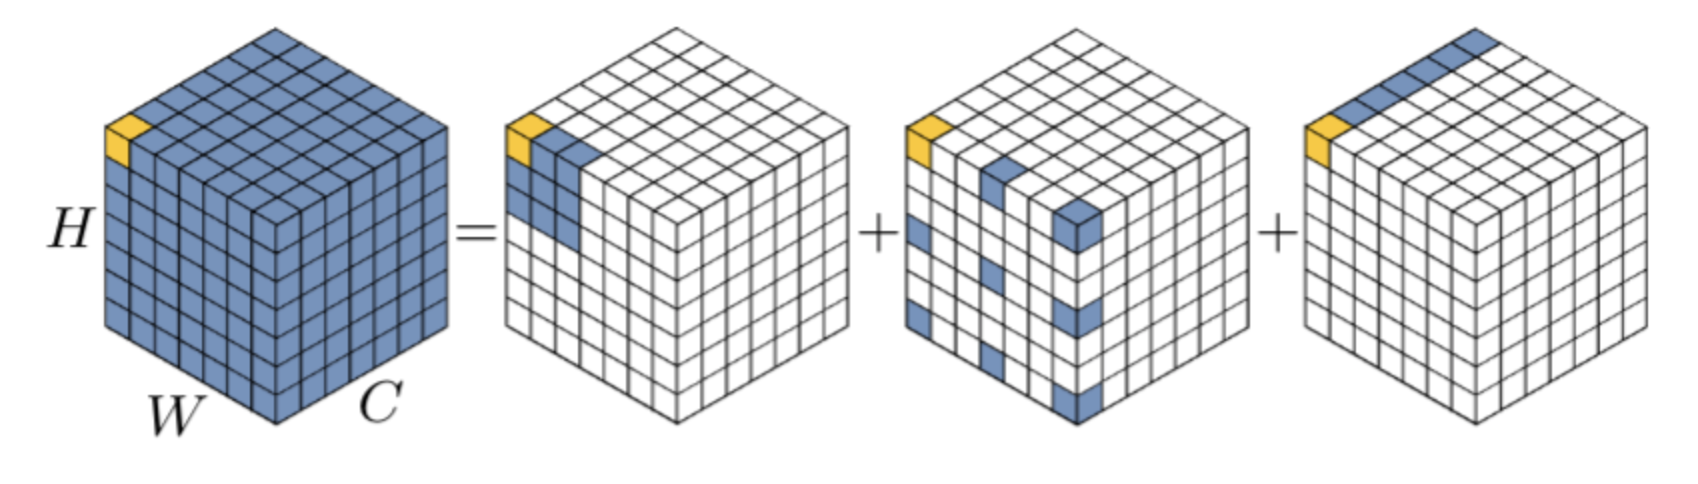

In [8]:
class LayerNorm(layers.LayerNormalization):
  # Overload defaults and casting to use fused implementation

  def __init__(self, epsilon=1.001e-5, dtype='float32', **kwargs):
    kwargs['autocast'] = False
    super().__init__(epsilon=epsilon, dtype=dtype, **kwargs)

  def build(self, input_shape):
    super().build(input_shape)
    if not self._fused:
      warnings.warn(f'Layer {self.name} will use an inefficient implementation.')

  def call(self, inputs, *args, **kwargs):
    outputs = tf.cast(inputs, 'float32')
    outputs = super().call(outputs)

    if inputs.dtype == tf.dtypes.float16:
      outputs = tf.clip_by_value(outputs, tf.dtypes.float16.min, tf.dtypes.float16.max)
    outputs = tf.cast(outputs, inputs.dtype)

    return outputs

In [9]:
class DropPath(layers.Layer):
  """Drop Path also known as the Stochastic Depth layer.

    Refernece:
        - https://keras.io/examples/vision/cct/#stochastic-depth-for-regularization
        - github.com:rwightman/pytorch-image-models
  """
  def __init__(self, drop_prob=None, **kwargs):
    super(DropPath, self).__init__(**kwargs)
    self.drop_prob = drop_prob
  
  #@tf.function(jit_compile=True)
  def call(self, x):
    input_shape = tf.shape(x)
    batch_size = input_shape[0]
    rank = x.shape.rank
    shape = (batch_size,) + (1,) * (rank - 1)
    random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
    path_mask = tf.floor(random_tensor)
    output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
    return output

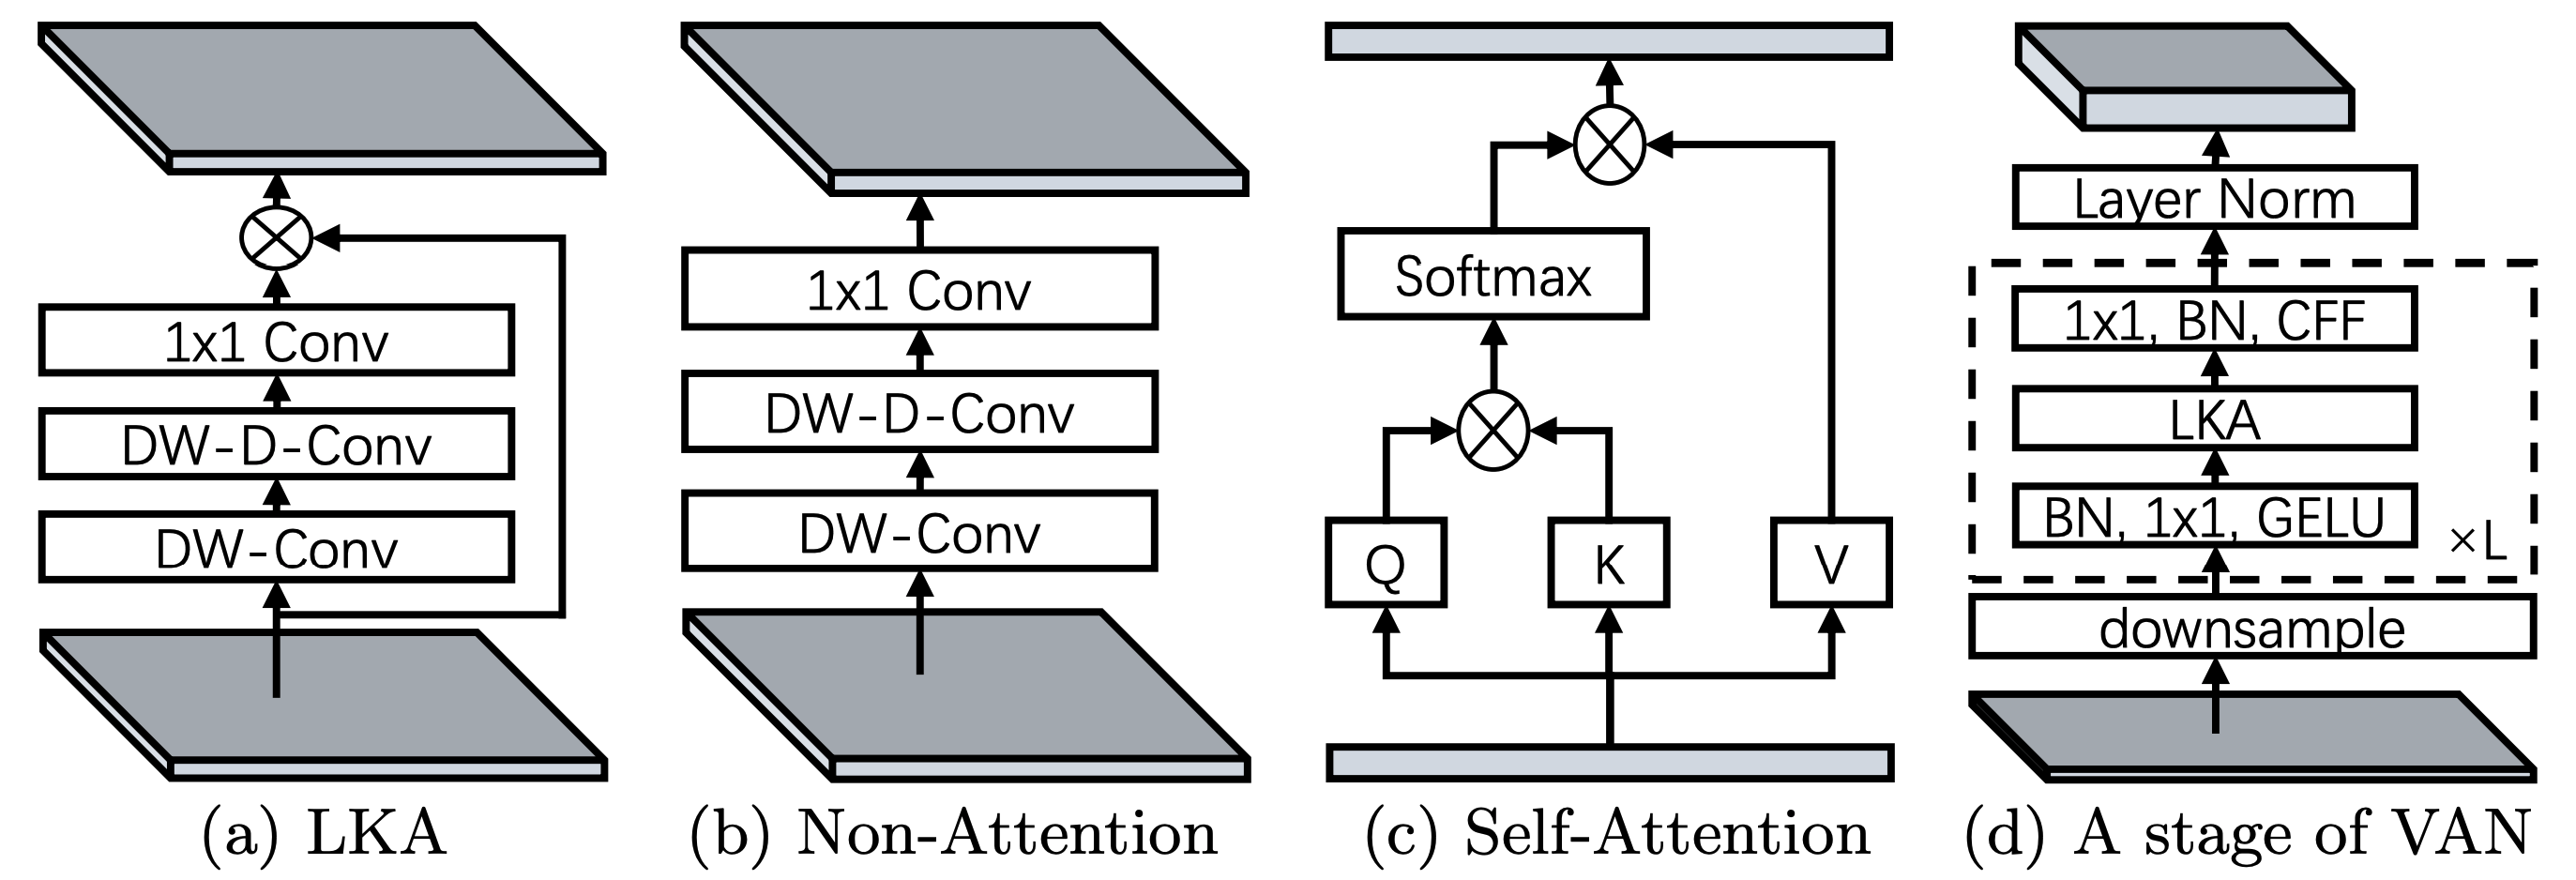

In [10]:
class LKA(layers.Layer):
  def __init__(self, dim):
    super(LKA,self).__init__()
    
    self.conv0 = layers.DepthwiseConv2D(5, padding='same',name='conv0')
    self.conv_spatial = layers.DepthwiseConv2D(7, padding='same', dilation_rate=3, name='conv_spatial')
    self.conv1 = layers.Conv2D(dim, 1, name='conv1')
    
  #@tf.function(jit_compile=True) 
  def call(self, x):
    u = x        
    attn = self.conv0(x)
    attn = self.conv_spatial(attn)
    attn = self.conv1(attn)

    return u * attn

class Attention(layers.Layer):
  
  def __init__(self, d_model,**kwargs):
    super(Attention,self).__init__(**kwargs)

    self.proj_1 = layers.Conv2D(d_model, 1, name='proj_1')
    self.activation = tfa.layers.GELU()
    self.spatial_gating_unit = LKA(d_model)
    self.proj_2 = layers.Conv2D(d_model, 1, name='proj_2')
  
  #@tf.function(jit_compile=True) 
  def call(self, x):
    shorcut = x
    x = self.proj_1(x)
    x = self.activation(x)
    x = self.spatial_gating_unit(x)
    x = self.proj_2(x)
    x = x + shorcut
    return x

In [11]:
class Block(layers.Layer):

  def __init__(self, dim, mlp_ratio=4., drop=0.,drop_path=0., act_layer=tfa.layers.GELU):
    super(Block, self).__init__()
    
    self.norm1 = layers.BatchNormalization(name='norm1', epsilon=1.001e-5)
    self.attn = Attention(dim,name='attn')
    self.drop_path = DropPath(drop_path)

    self.norm2 = layers.BatchNormalization(name='norm2', epsilon=1.001e-5)
    
    mlp_hidden_dim = int(dim * mlp_ratio)
    self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
    
    layer_scale_init_value = 1e-2            
    self.layer_scale_1 = self.add_weight(
      'layer_scale_1', shape=[1, 1, 1, dim], initializer=initializers.Constant(layer_scale_init_value),
      trainable=True, dtype=self.dtype)

    self.layer_scale_2 = self.add_weight(
      'layer_scale_2', shape=[1, 1, 1, dim], initializer=initializers.Constant(layer_scale_init_value),
      trainable=True, dtype=self.dtype)
  
  #@tf.function(jit_compile=True) 
  def call(self, x):
    x = x + self.drop_path(self.layer_scale_1 * self.attn(self.norm1(x)))
    x = x + self.drop_path(self.layer_scale_2 * self.mlp(self.norm2(x)))
    return x

In [12]:
class VAN(layers.Layer):

  def __init__(self, img_size=224, num_classes=1000, embed_dims=[64, 128, 256, 512],
               mlp_ratios=[4, 4, 4, 4], drop_rate=0., drop_path_rate=0., norm_layer= LayerNorm,
               depths=[3, 4, 6, 3], num_stages=4, flag=False):
    
    super(VAN, self).__init__()
    if flag == False:
      self.num_classes = num_classes
    self.depths = depths
    self.num_stages = num_stages

    dpr = [x for x in np.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
    cur = 0

    for i in range(num_stages):
      patch_embed = OverlapPatchEmbed(img_size=img_size if i == 0 else img_size // (2 ** (i + 1)),
                                      patch_size=7 if i == 0 else 3,
                                      stride=4 if i == 0 else 2,
                                      embed_dim=embed_dims[i])

      block = [Block(dim=embed_dims[i], mlp_ratio=mlp_ratios[i], drop=drop_rate, drop_path=dpr[cur + j])
                for j in range(depths[i])]
      norm = norm_layer(embed_dims[i])
      cur += depths[i]

      setattr(self, f"patch_embed{i + 1}", patch_embed)
      setattr(self, f"block{i + 1}", block)
      setattr(self, f"norm{i + 1}", norm)

    # classification head
    self.flatten = layers.GlobalAveragePooling2D(name='avg_pool')
    self.head = layers.Dense(num_classes, name='head')  

  def get_classifier(self):
    return self.head

  def reset_classifier(self, num_classes, global_pool=''):
    self.num_classes = num_classes
    self.head = layers.Dense(num_classes, name='head')  

  def forward_features(self, x):

    for i in range(self.num_stages):
      patch_embed = getattr(self, f"patch_embed{i + 1}")
      block = getattr(self, f"block{i + 1}")
      norm = getattr(self, f"norm{i + 1}")
      x = patch_embed(x)
      for blk in block:
        x = blk(x)   
      x = norm(x)

    return self.flatten(x)
  
  #@tf.function(jit_compile=True) 
  def call(self, x):
    x = self.forward_features(x)
    x = self.head(x)

    return x

In [13]:
def van_tiny(pretrained=False, **kwargs):
  model = VAN(embed_dims=[32, 64, 160, 256], mlp_ratios=[8, 8, 4, 4], 
              depths=[3, 3, 5, 2],**kwargs)
  return model

def van_small(pretrained=False, **kwargs):
  model = VAN(embed_dims=[64, 128, 320, 512], mlp_ratios=[8, 8, 4, 4], 
              depths=[2, 2, 4, 2],**kwargs)
  return model

def van_base(pretrained=False, **kwargs):
  model = VAN(embed_dims=[64, 128, 320, 512], mlp_ratios=[8, 8, 4, 4],
              depths=[3, 3, 12, 3],**kwargs)
  return model

def van_large(pretrained=False, **kwargs):
  model = VAN(embed_dims=[64, 128, 320, 512], mlp_ratios=[8, 8, 4, 4],
              depths=[3, 5, 27, 3],**kwargs)
  return model

In [14]:
model = van_tiny()
model.build(input_shape=(256,256,3))

img = tf.random.uniform(shape=[1, 256, 256, 3])
preds = model(img)
print(preds.shape) # (1, 1000)

(1, 1000)


## Compile, train, and evaluate the mode

In [15]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
  """A LearningRateSchedule that uses a warmup cosine decay schedule."""

  def __init__(self, lr_start, lr_max, warmup_steps, total_steps):
    """
    Args:
      lr_start: The initial learning rate
      lr_max: The maximum learning rate to which lr should increase to in
              the warmup steps
      warmup_steps: The number of steps for which the model warms up
      total_steps: The total number of steps for the model training
    """
    super().__init__()
    self.lr_start = lr_start
    self.lr_max = lr_max
    self.warmup_steps = warmup_steps
    self.total_steps = total_steps
    self.pi = tf.constant(np.pi)

  def __call__(self, step):
    # Check whether the total number of steps is larger than the warmup
    # steps. If not, then throw a value error.
    if self.total_steps < self.warmup_steps:
      raise ValueError(
          f"Total number of steps {self.total_steps} must be"
          + f"larger or equal to warmup steps {self.warmup_steps}."
          )

    # `cos_annealed_lr` is a graph that increases to 1 from the initial
    # step to the warmup step. After that this graph decays to -1 at the
    # final step mark.
    cos_annealed_lr = tf.cos(
        self.pi
        * (tf.cast(step, tf.float32) - self.warmup_steps)
        / tf.cast(self.total_steps - self.warmup_steps, tf.float32)
        )

    # Shift the mean of the `cos_annealed_lr` graph to 1. Now the grpah goes
    # from 0 to 2. Normalize the graph with 0.5 so that now it goes from 0
    # to 1. With the normalized graph we scale it with `lr_max` such that
    # it goes from 0 to `lr_max`
    learning_rate = 0.5 * self.lr_max * (1 + cos_annealed_lr)

    # Check whether warmup_steps is more than 0.
    if self.warmup_steps > 0:
      # Check whether lr_max is larger that lr_start. If not, throw a value
      # error.
      if self.lr_max < self.lr_start:
        raise ValueError(
            f"lr_start {self.lr_start} must be smaller or"
            + f"equal to lr_max {self.lr_max}."
            )

      # Calculate the slope with which the learning rate should increase
      # in the warumup schedule. The formula for slope is m = ((b-a)/steps)
      slope = (self.lr_max - self.lr_start) / self.warmup_steps

      # With the formula for a straight line (y = mx+c) build the warmup
      # schedule
      warmup_rate = slope * tf.cast(step, tf.float32) + self.lr_start

      # When the current step is lesser that warmup steps, get the line
      # graph. When the current step is greater than the warmup steps, get
      # the scaled cos graph.
      learning_rate = tf.where(step < self.warmup_steps, warmup_rate, learning_rate)

    # When the current step is more that the total steps, return 0 else return
    # the calculated graph.
    return tf.where(step > self.total_steps, 0.0, learning_rate, name="learning_rate")

In [16]:
def run_experiment(model):
  
  # Get the total number of steps for training.
  total_steps = int((len(x_train) / batch_size) * num_epochs)

  # Calculate the number of steps for warmup.
  warmup_epoch_percentage = 0.15
  warmup_steps = int(total_steps * warmup_epoch_percentage)

  # Initialize the warmupcosine schedule.
  scheduled_lrs = WarmUpCosine(
    lr_start=1e-5, lr_max=1e-3, warmup_steps=warmup_steps, total_steps=total_steps,
  )
  
  optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
  )

  model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
  )

  checkpoint_filepath = "/tmp/checkpoint"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
  )

  history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
  )

  model.load_weights(checkpoint_filepath)
  _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")
  print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

  return history

In [17]:
class van_classifier(keras.Model):
  
  def __init__(self):
    
    super(van_classifier, self).__init__()
    self.aug = data_augmentation
    self.van = van_tiny()
   
  def call(self, inputs):
    x = self.aug(inputs)
    return self.van(x)

In [18]:
classifier = van_classifier()
classifier.build(input_shape=(batch_size,32,32,3))
history = run_experiment(classifier)

Epoch 1/30
176/176 [==============================] - 100s 408ms/step - loss: 4.7759 - accuracy: 0.0705 - top-5-accuracy: 0.2341 - val_loss: 3.9952 - val_accuracy: 0.0976 - val_top-5-accuracy: 0.2950
Epoch 2/30
176/176 [==============================] - 54s 308ms/step - loss: 3.6639 - accuracy: 0.1320 - top-5-accuracy: 0.3672 - val_loss: 3.5427 - val_accuracy: 0.1524 - val_top-5-accuracy: 0.4034
Epoch 3/30
176/176 [==============================] - 54s 308ms/step - loss: 3.3883 - accuracy: 0.1773 - top-5-accuracy: 0.4492 - val_loss: 3.2886 - val_accuracy: 0.1932 - val_top-5-accuracy: 0.4778
Epoch 4/30
176/176 [==============================] - 54s 308ms/step - loss: 3.1524 - accuracy: 0.2159 - top-5-accuracy: 0.5123 - val_loss: 3.0844 - val_accuracy: 0.2304 - val_top-5-accuracy: 0.5388
Epoch 5/30
176/176 [==============================] - 54s 308ms/step - loss: 2.9321 - accuracy: 0.2585 - top-5-accuracy: 0.5709 - val_loss: 2.8757 - val_accuracy: 0.2822 - val_top-5-accuracy: 0.5888
Epoc

The tiny VAN model easily achieves around 52% accuracy and
80% top-5 accuracy on the test data with just 30 epoches. Easier and fater to train than Vit model.